In [ ]:
import cv2 as cv
from PIL import Image
import os
import numpy as np
from keras.preprocessing.image import img_to_array

import warnings
warnings.filterwarnings('ignore')

In [2]:
x = []
y = []

for dname, _, fname in os.walk('samples/'):
    for fn in fname:
        path = os.path.join(dname, fn)
        image = cv.imread(path, cv.IMREAD_GRAYSCALE)
        image = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)
        kernel = np.ones((5, 5), np.uint8)
        image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
        kernel = np.ones((2, 2), np.uint8)
        image = cv.dilate(image, kernel, iterations=1)
        image = cv.GaussianBlur(image, (5, 5), 0)
        temp = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90], image[10:50, 90:110], image[10:50, 110:130]]
        for i in range(5):
            x.append(img_to_array(Image.fromarray(temp[i])))
            y.append(path[len(path)-9:len(path)-4][i])

x = np.array(x)
y = np.array(y)

x.shape, y.shape

((10700, 40, 20, 1), (10700,))

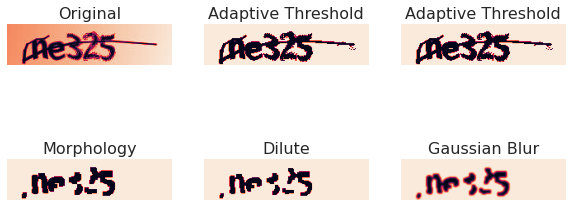

In [58]:
fig = plt.figure(figsize=(10, 7))

row, col = 3, 3
temp = './samples/ne325.png'

img1 = cv.imread(temp, cv.IMREAD_GRAYSCALE)
img2 = cv.adaptiveThreshold(img1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)
img3 = cv.adaptiveThreshold(img2, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)
kernel = np.ones((5,5),np.uint8)
img4 = cv.morphologyEx(img3, cv.MORPH_CLOSE, kernel)
kernel = np.ones((2,2),np.uint8)
img5 = cv.dilate(img4, kernel, iterations = 1)
img6 = cv.GaussianBlur(img5, (5,5), 0)

fig.add_subplot(row, col, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Original', size=16)

fig.add_subplot(row, col, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Adaptive Threshold', size=16)

fig.add_subplot(row, col, 3)
plt.imshow(img3)
plt.axis('off')
plt.title('Adaptive Threshold', size=16)

fig.add_subplot(row, col, 4)
plt.imshow(img4)
plt.axis('off')
plt.title('Morphology', size=16)

fig.add_subplot(row, col, 5)
plt.imshow(img5)
plt.axis('off')
plt.title('Dilute', size=16)

fig.add_subplot(row, col, 6)
plt.imshow(img6)
plt.axis('off')
plt.title('Gaussian Blur', size=16)

plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
x = x.astype('float32')
x/=255

le = LabelEncoder().fit_transform(y)
ohe = OneHotEncoder(sparse=False).fit_transform(le.reshape(len(le), 1))

x_train, x_test, y_train, y_test = train_test_split(x, ohe, test_size=0.2, random_state=35, shuffle=True)

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8560, 40, 20, 1), (8560, 19), (2140, 40, 20, 1), (2140, 19))

In [6]:
h, w = x.shape[1], x.shape[2] # input shape
c = 1 # color channel
node = ohe.shape[1] # last layer

In [7]:
import keras
import tensorflow as tf

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [ ]:
model = Sequential([
    Input(shape=(h, w, c)),
    
    Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    Flatten(),
    Dropout(0.4),
    
    Dense(1500, activation='relu'),
    Dropout(0.2),
    
    Dense(node, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 5, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 5, 32)         4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 3, 32)         0

In [10]:
model.compile(
    optimizer = 'adam' ,
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
early_stop = [
    tf.keras.callbacks.EarlyStopping(
        patience=5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        verbose=1,
        monitor='val_loss',
        save_best_weight=True,
        model='auto'
    )
]

In [12]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=early_stop,
    shuffle=True
)

Epoch 1/50
264/268 [============================>.] - ETA: 0s - loss: 1.7348 - accuracy: 0.4750
Epoch 00001: saving model to model.h5
268/268 [==============================] - 3s 11ms/step - loss: 1.7250 - accuracy: 0.4792 - val_loss: 0.8203 - val_accuracy: 0.7701
Epoch 2/50
264/268 [============================>.] - ETA: 0s - loss: 0.7740 - accuracy: 0.7810
Epoch 00002: saving model to model.h5
268/268 [==============================] - 3s 10ms/step - loss: 0.7747 - accuracy: 0.7806 - val_loss: 0.5211 - val_accuracy: 0.8477
Epoch 3/50
264/268 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.8312
Epoch 00003: saving model to model.h5
268/268 [==============================] - 3s 10ms/step - loss: 0.5874 - accuracy: 0.8314 - val_loss: 0.3968 - val_accuracy: 0.8846
Epoch 4/50
268/268 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.8520
Epoch 00004: saving model to model.h5
268/268 [==============================] - 3s 11ms/step - loss: 0.49

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

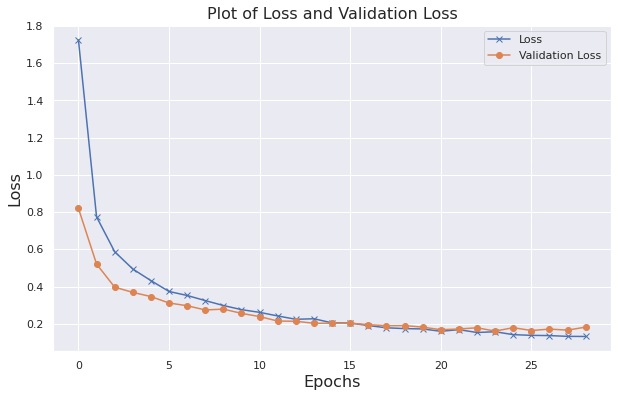

In [14]:
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], '-x',label='Loss')
plt.plot(history.history['val_loss'], '-o',label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', size=16)
plt.ylabel('Loss', size=16)
plt.title('Plot of Loss and Validation Loss', size=16)
plt.show()

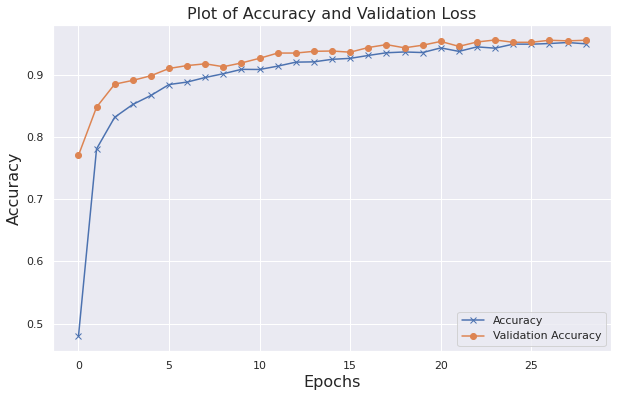

In [77]:
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], '-x', label='Accuracy')
plt.plot(history.history['val_accuracy'], '-o', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs', size=16)
plt.ylabel('Accuracy', size=16)
plt.title('Plot of Accuracy and Validation Loss', size=16)
plt.show()

In [16]:
model.evaluate(x_test, y_test)

67/67 [==============================] - 0s 3ms/step - loss: 0.1823 - accuracy: 0.9551


[0.1822603940963745, 0.9551401734352112]

In [18]:
info = {le[i] : y[i] for i in range(len(y))}

def prediction (img_path) :
    
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    image = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)
    image = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv.dilate(image, kernel, iterations = 1)
    image = cv.GaussianBlur(image, (5,5), 0)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

In [60]:
import glob

img = glob.glob('./samples/*.png')

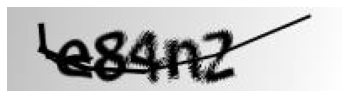

Prediction: e84m2
Actual:     e84n2


In [68]:
prediction(img[629])